In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 8 # that's default image size for this interactive session

In [2]:
import shm_kmer_model_estimator.standard_model_estimations as standard_model_estimations

In [3]:
full_all_chains_model = standard_model_estimations.full_all_chains_model()
full_igh_model = standard_model_estimations.full_igh_model()

In [4]:
all_chains_igh = full_all_chains_model['NoKNeighbours']['IGH']
all_chains_igl = full_all_chains_model['NoKNeighbours']['IGL']
all_chains_igk = full_all_chains_model['NoKNeighbours']['IGK']

# Mutability

In [5]:
import sample_reader.standard_samples as standard_samples

heavy_samples  = standard_samples.concatenate_kmer_freq_matrices('IGH')
lambda_samples = standard_samples.concatenate_kmer_freq_matrices('IGL')
kappa_samples  = standard_samples.concatenate_kmer_freq_matrices('IGK')

In [6]:
import pandas as pd
import scipy as sp
from mutability_diversity.calculate_mutability_diversity import *

def diversity_boxplot_cross_chains(kmer,
                                   heavy_samples=standard_samples.concatenate_kmer_freq_matrices('IGH'),
                                   lambda_samples=standard_samples.concatenate_kmer_freq_matrices('IGL'),
                                   kappa_samples=standard_samples.concatenate_kmer_freq_matrices('IGK'),
                                   diversity_function=calculate_mutability,
                                   plot=False,
                                   balanced_design=True,
                                   statistics_function=sp.stats.mstats.kruskalwallis):
    f = (lambda x: calculate_mutability_diversity(x, diversity_function, good_coverage_indices=[0]))
    nd_1d = (lambda x: np.array(x).flatten())
    _, heavy_diversity  = f(heavy_samples.loc[:, [kmer], :])
    _, lambda_diversity = f(lambda_samples.loc[:, [kmer], :])
    _, kappa_diversity  = f(kappa_samples.loc[:, [kmer], :])
    
    if isinstance(heavy_diversity, pd.DataFrame):
        heavy_diversity.columns = ['Heavy']
        lambda_diversity.columns = ['Lambda']
        kappa_diversity.columns = ['Kappa']
    if isinstance(heavy_diversity, pd.Panel):
        heavy_diversity.items = ['Heavy']
        lambda_diversity.items = ['Lambda']
        kappa_diversity.items = ['Kappa']
    
    all_chain_data = pd.concat((heavy_diversity,
                                lambda_diversity,
                                kappa_diversity
                               ), axis=1)
    if plot:
        g = sns.boxplot(all_chain_data)
        plt.title(kmer)
    
    if isinstance(heavy_diversity, pd.DataFrame):
        heavy_diversity  = nd_1d(heavy_diversity)
        lambda_diversity = nd_1d(lambda_diversity)
        kappa_diversity  = nd_1d(kappa_diversity)
    if isinstance(heavy_diversity, pd.Panel):
        heavy_diversity  = np.array(heavy_diversity['Heavy']).T
        lambda_diversity = np.array(lambda_diversity['Lambda']).T
        kappa_diversity  = np.array(kappa_diversity['Kappa']).T
    if balanced_design:
        if isinstance(heavy_diversity, pd.DataFrame):
            return statistics_function(heavy_diversity[:len(lambda_diversity)],
                                       lambda_diversity, kappa_diversity)
        if isinstance(heavy_diversity, pd.Panel):
            return statistics_function(heavy_diversity.loc[:,:,:len(lambda_diversity)],
                                       lambda_diversity, kappa_diversity)
    return statistics_function(heavy_diversity, lambda_diversity, kappa_diversity)

In [7]:
def filter_multichain_kmers():
    import kmer_utilities.filtering_kmers_utilities as filtering_kmers_utilities
    import sample_reader.standard_samples as standard_samples
    good_coverage_ind = np.array([True] * 1024)
    for chain_type in ['IGH', 'IGK', 'IGL']:
        indexes_chain_type, _ = \
        filtering_kmers_utilities.filter_by_coverage(
            standard_samples.concatenate_kmer_freq_matrices(chain_type=chain_type, strategy='NoKNeighbours'))
        good_coverage_ind *= indexes_chain_type
    
    import kmer_utilities.kmer_utilities as kmer_utilities
    good_coverage_kmers = np.array(kmer_utilities.kmer_names())[good_coverage_ind]
    return good_coverage_kmers

In [8]:
def pvalue_distr(good_coverage_kmers=filter_multichain_kmers(),
                 balanced_design=True,
                 statistics_function=sp.stats.mstats.kruskalwallis,
                 diversity_function=calculate_mutability):
    pvalues = []
    for kmer in good_coverage_kmers:
        pvalues.append(diversity_boxplot_cross_chains(kmer,
                                                      balanced_design=balanced_design,
                                                      statistics_function=statistics_function,
                                                      diversity_function=diversity_function).pvalue)
    pvalues = np.array(pvalues)
    return pvalues

0.82051282051282048

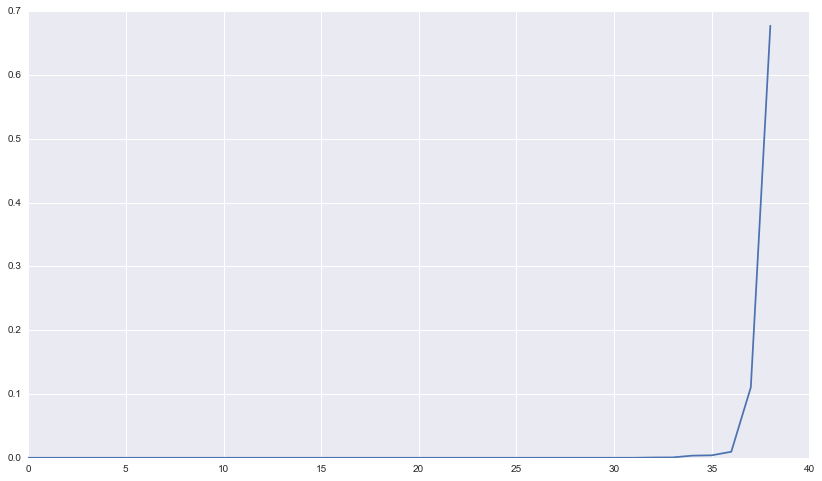

In [14]:
anova = sp.stats.f_oneway
kruskalwallis = sp.stats.mstats.kruskalwallis
pvalues = pvalue_distr(statistics_function=kruskalwallis, balanced_design=False)
pvalues.sort()

plt.plot(pvalues)
signif_level = 0.01
np.mean(pvalues < signif_level / len(pvalues))
#sns.distplot(range(len(pvalues)), pvalues)

In [10]:
anova([[1, 2, 3], [2, 3, 4]], [[1, 2, 3], [2, 3, 4]])

F_onewayResult(statistic=array([ 0.,  0.,  0.]), pvalue=array([ 1.,  1.,  1.]))

In [11]:
import math_special_functions.manova as manova

0.97435897435897434

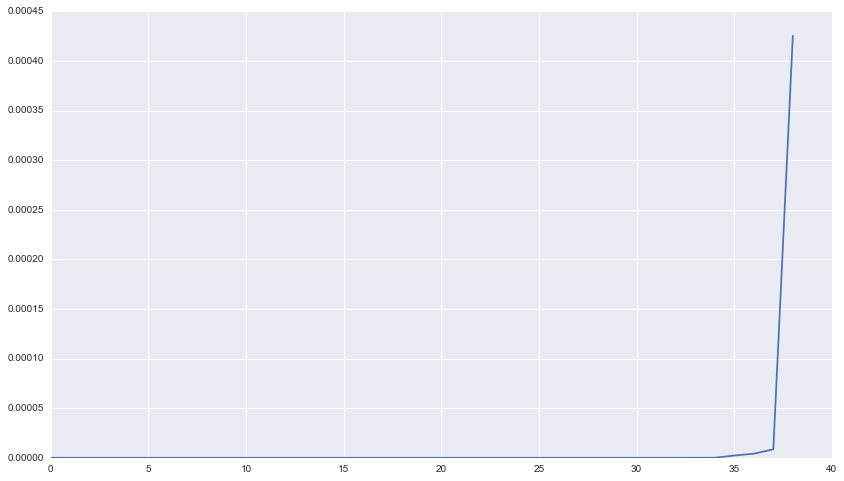

In [12]:
pvalues = pvalue_distr(statistics_function=manova.manova_wilks, balanced_design=True,
                       diversity_function=calculate_full_substitution)
pvalues.sort()

plt.plot(pvalues)
signif_level = 0.01
np.mean(pvalues < signif_level / len(pvalues))
#sns.distplot(range(len(pvalues)), pvalues)